In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle 
from tqdm import tqdm 
import shap

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

SEED = 42

/home/WUR/g0012069/env/main/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/WUR/g0012069/env/main/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(

In [2]:
class Object:
    def __init__(self, file_path, normalize=False):
        self.data = pd.read_pickle(file_path)
        
        if normalize:
            self._normalize_data()

        if 'type' in self.data.columns:
            self.X = self.data.drop('type', axis=1).copy()
            self.y = self.data['type'].copy()
            self.labels = None
            
            self._create_class_labels()
            
            self.X_train = None
            self.y_train = None
            self.X_test = None
            self.y_test = None
        
        else:
            self.X = self.data.copy()
            self.y = None

        # Define classifiers
        self.classifiers = {
            'LR':  LogisticRegression(max_iter=10000),
            'kNN': KNeighborsClassifier(),
            'SVM': SVC(probability=True),
            'RF': RandomForestClassifier(),
            'LDA': LinearDiscriminantAnalysis(),
            'GNB': GaussianNB(),
            'XGB': XGBClassifier()
        }

        # Define hyperparameter grid for each model
        LR_param_grid = {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
        }

        kNN_param_grid = {
            'n_neighbors': np.arange(1, 20),
            'weights': ['uniform', 'distance']
        }

        SVM_param_grid = {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
        }

        RF_param_grid = {
            'n_estimators': [100, 200, 300],  
            'max_depth': [None, 5, 10],       
            'min_samples_split': [2, 5, 10],  
            'min_samples_leaf': [1, 2, 4],  
            'max_features': ['sqrt', 'log2']
        }

        GNB_param_grid = {
            'var_smoothing': np.logspace(-13, -3, 100)
        }        
        
        LDA_param_grid = {
            'solver': ['svd', 'lsqr', 'eigen'],
        }

        XGB_param_grid = {
            'n_estimators': [100, 300, 500, 600, 700, 800, 1200],
            'learning_rate': [0.01, 0.1, 0.0001, 0.5, 0.2],
            'max_depth': [3, 4, 5, 8, 12, 18],
            'subsample': np.arange(0.5, 1.0, 0.1),
            'colsample_bytree': np.arange(0.5, 1.0, 0.1),
            'gamma': [0.001, 0.01, 0.1, 0, 1, 2]
        }

        # Define the parameter grids
        self.param_grids = {
            'LR': LR_param_grid,
            'kNN': kNN_param_grid,
            'SVM': SVM_param_grid,
            'RF': RF_param_grid,
            'GNB': GNB_param_grid,
            'LDA': LDA_param_grid,
            'XGB': XGB_param_grid
        }
        
        self.model = None
        self.y_pred = None

    def _normalize_data(self):
        numerical_columns = self.data.select_dtypes(include=['float64', 'int64']).columns
        print(f'Normalizing {len(numerical_columns)} columns...')
        scl= StandardScaler()
        self.data[numerical_columns] = scl.fit_transform(self.data[numerical_columns])

    def _create_class_labels(self):
        self.labels = LabelEncoder().fit_transform(self.y)

    def split_dataset(self, test_size=0.25):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.labels, stratify=self.labels, test_size=test_size, random_state=42)
        print(self.X_train.shape, self.X_test.shape)

    def _save_model(self, model_name):
        with open(f'estimators/{model_name}', 'wb') as file:
            pickle.dump(self.model, file)

    def tune_model(self, model_name):
        # Create a RandomizedSearchCV object
        random_search = RandomizedSearchCV(
            estimator=self.classifiers[model_name],
            param_distributions=self.param_grids[model_name],
            n_iter=100,  # Number of parameter settings that are sampled
            scoring='accuracy',
            n_jobs=-1,  # Use all available cores
            cv=3,  # Number of cross-validation 
            verbose=1,
            random_state=42
        )

        # Fit the RandomizedSearchCV object to the training data
        random_search.fit(self.X_train, self.y_train)
        # Get the best parameter combination found by RandomizedSearchCV
        best_params = random_search.best_params_
        # Create a new XGBoost classifier with the best parameters
        self.model = random_search.best_estimator_
        # Train the classifier on the training data
        self.model.fit(self.X_train, self.y_train)
        # Make predictions on the test data
        self.y_pred = self.model.predict(self.X_test)
        # Evaluate the accuracy of the classifier
        accuracy = accuracy_score(self.y_test, self.y_pred)
        print("Accuracy:", accuracy)
        self._save_model(model_name)

    def nested_cv(self, model_name):
        NUM_TRIALS = 3
        # Arrays to store scores
        nested_scores = []
        # Loop for each trial
        for i in tqdm(range(NUM_TRIALS)):
            
            inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=i)
            outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)

            # Nested CV with parameter optimization
            clf = RandomizedSearchCV(estimator=self.classifiers[model_name], scoring='accuracy', param_distributions=self.param_grids[model_name], 
                                     cv=inner_cv, n_iter=100, n_jobs=-1, verbose=0)
            
            nested_score = cross_val_score(clf, X=self.X_train, y=self.y_train, 
                                        scoring='accuracy', cv=outer_cv)
            
            nested_scores.append(list(nested_score))
        return clf, nested_scores
        

    def __str__(self) -> str:
        return f'Shape of dataset: {self.data.shape}'

MyData = Object('data/ICC_rms.pkl')     
MyData.split_dataset()

(1158, 511) (386, 511)


## NestedCV

In [4]:
nested_LG, nested_scores_LG = MyData.nested_cv('LR')
nested_kNN, nested_scores_kNN = MyData.nested_cv('kNN')
nested_SVM, nested_scores_SVM = MyData.nested_cv('SVM')
nested_RF, nested_scores_RF = MyData.nested_cv('RF')
nested_LDA, nested_scores_LDA = MyData.nested_cv('LDA')
nested_GNB, nested_scores_GNB = MyData.nested_cv('GNB')

  0%|          | 0/3 [00:00<?, ?it/s]The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.
 33%|███▎      | 1/3 [00:06<00:13,  6.98s/it]The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 6 is smaller 

In [5]:
nested_scores_LG = [item for sublist in nested_scores_LG for item in sublist]
nested_scores_kNN = [item for sublist in nested_scores_kNN for item in sublist]
nested_scores_RF = [item for sublist in nested_scores_RF for item in sublist]
nested_scores_SVM = [item for sublist in nested_scores_SVM for item in sublist]
nested_scores_LDA = [item for sublist in nested_scores_LDA for item in sublist]
nested_scores_GNB = [item for sublist in nested_scores_GNB for item in sublist]

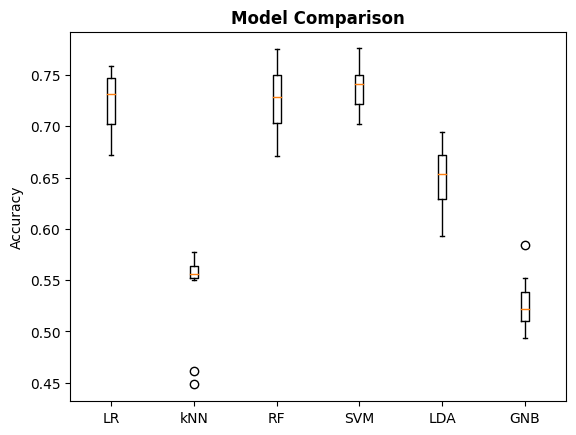

In [6]:
# create box plot
fig, ax = plt.subplots()
positions = [1, 2, 3, 4, 5, 6] # x-axis positions for each box plot
ax.boxplot([nested_scores_LG, nested_scores_kNN, nested_scores_RF, nested_scores_SVM, nested_scores_LDA, nested_scores_GNB], positions=positions, widths=0.1)

# add title and labels
ax.set_title('Model Comparison', fontweight='bold')
ax.set_ylabel('Accuracy')
ax.set_xticks(positions)
ax.set_xticklabels(['LR', 'kNN', 'RF', 'SVM', 'LDA', 'GNB'])

# show plot
plt.show()

## Model Tuning

In [8]:
MyData.tune_model(model_name='SVM')
MyData.tune_model(model_name='LR')
MyData.tune_model('RF')
MyData.tune_model('XGB')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Accuracy: 0.7409326424870466
Fitting 3 folds for each of 6 candidates, totalling 18 fits


The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.


Accuracy: 0.6917098445595855
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Accuracy: 0.7357512953367875
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Accuracy: 0.7538860103626943


## Ensemble models using Voting Mechanism

In [7]:
models = {}
estimators = ['LR', 'RF', 'SVM', 'XGB']
for estimator in estimators:
    with open(f'estimators/{estimator}', 'rb') as f:
        models[estimator] = pickle.load(f)
# Example usage: accessing the models
lr = models['LR']
rf = models['RF']
svm = models['SVM']
xgb = models['XGB']

In [8]:
for m in models:
    print(m)
    y_pred = models[m].predict(MyData.X_test)
    accuracy = accuracy_score(MyData.y_test, y_pred)
    print(f'Accuracy: {round(accuracy, 4)}')

LR
Accuracy: 0.6917
RF
Accuracy: 0.7358
SVM
Accuracy: 0.7409
XGB
Accuracy: 0.7539


In [9]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(
    estimators=[('LR', lr), ('RF', rf), ('SVM', svm), ('XGB', xgb)],
    voting='hard'  
)

# Fit the ensemble on your training data
ensemble.fit(MyData.X_train, MyData.y_train)

# Predict using the ensemble
y_pred = ensemble.predict(MyData.X_test)
accuracy = accuracy_score(MyData.y_test, y_pred)
print(accuracy)

0.7305699481865285


## ANN 

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network model
class BinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size * 2)
        self.fc3 = nn.Linear(hidden_size * 2, hidden_size)
        self.linear = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.5)  

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

In [11]:
# Convert the training and testing sets to tensors
X_train = torch.tensor(MyData.X_train.values, dtype=torch.float32)
y_train = torch.tensor(MyData.y_train, dtype=torch.float32)
X_test = torch.tensor(MyData.X_test.values, dtype=torch.float32)
y_test = torch.tensor(MyData.y_test, dtype=torch.float32)

# Reshape the labels
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [12]:
# Create an instance of the model
input_size = X_train.shape[1]  # Number of features in the input data
hidden_size = 500  # Number of units in the hidden layer
model = BinaryClassifier(input_size, hidden_size)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 250 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Test the model
predictions = model(X_test)
y_pred = predictions.round().detach().numpy()

Epoch 250/10000, Loss: 0.6859123706817627
Epoch 500/10000, Loss: 0.681123673915863
Epoch 750/10000, Loss: 0.676009476184845
Epoch 1000/10000, Loss: 0.6685258150100708
Epoch 1250/10000, Loss: 0.6569483280181885
Epoch 1500/10000, Loss: 0.6364502310752869
Epoch 1750/10000, Loss: 0.6105278134346008
Epoch 2000/10000, Loss: 0.5884885191917419
Epoch 2250/10000, Loss: 0.5664422512054443
Epoch 2500/10000, Loss: 0.5471040606498718
Epoch 2750/10000, Loss: 0.5257051587104797
Epoch 3000/10000, Loss: 0.5123700499534607
Epoch 3250/10000, Loss: 0.48886367678642273
Epoch 3500/10000, Loss: 0.4625839293003082
Epoch 3750/10000, Loss: 0.47211816906929016
Epoch 4000/10000, Loss: 0.4734582006931305
Epoch 4250/10000, Loss: 0.44521141052246094
Epoch 4500/10000, Loss: 0.4420500099658966
Epoch 4750/10000, Loss: 0.4295314848423004
Epoch 5000/10000, Loss: 0.4223998785018921
Epoch 5250/10000, Loss: 0.40990403294563293
Epoch 5500/10000, Loss: 0.3979712426662445
Epoch 5750/10000, Loss: 0.3895024061203003
Epoch 6000/1

In [13]:
print(accuracy_score(y_test, y_pred))

0.7046632124352331


# Rules extraction

In [60]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import _tree

In [61]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []

    def recurse(node, path, paths):

        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]

    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]

    rules = []
    for path in paths:
        rule = "if "

        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]

    return rules

def rules_to_txt(rules, filename):

    # open file in write mode
    with open(r'../rules/'+filename, 'w') as fp:
        for item in rules:
            # write each item on a new line
            fp.write("%s\n" % item)

In [75]:
def surrogate(blackbox_model, X_train):
    y_pred_train = blackbox_model.predict(X_train)
    surrogate = DecisionTreeClassifier(random_state=SEED)
    surrogate.fit(X_train, y_pred_train)
    return surrogate

def extract_rules(surrogate):

    rules = get_rules(surrogate, feature_names=feature_names,
                  class_names=class_names)

    return rules

class_names = np.unique(MyData.y_train).astype(str)
feature_names = MyData.X_train.columns.values

surrogate = surrogate(xgb, MyData.X_train)
rules = extract_rules(surrogate)
rules[:10]


['if (650.51 > 0.674) and (740.53 <= 0.19) and (758.63 > 0.111) and (541.3 <= 0.426) and (589.35 > 0.037) and (776.59 <= 0.189) and (562.29 <= 0.118) and (888.57 <= 0.032) and (807.61 <= 0.239) and (593.39 > 0.017) and (729.47 <= 0.149) and (879.54 <= 0.036) and (707.56 > 0.163) then class: 1 (proba: 100.0%) | based on 128 samples',
 'if (650.51 <= 0.674) and (541.3 > 0.068) and (569.35 <= 0.406) and (850.7 <= 1.328) and (650.51 <= 0.509) and (788.72 <= 8.808) and (555.31 <= 3.361) and (620.43 <= 0.067) and (734.66 <= 11.362) and (842.59 <= 0.128) and (568.36 <= 0.106) and (534.29 <= 0.061) then class: 0 (proba: 100.0%) | based on 110 samples',
 'if (650.51 <= 0.674) and (541.3 <= 0.068) and (715.06 <= 0.169) and (706.58 <= 0.422) and (850.7 <= 0.044) and (689.44 <= 0.053) and (581.38 <= 0.041) and (844.68 <= 0.025) and (648.46 <= 0.024) then class: 0 (proba: 100.0%) | based on 74 samples',
 'if (650.51 <= 0.674) and (541.3 <= 0.068) and (715.06 <= 0.169) and (706.58 > 0.422) and (576.

In [98]:
def surrogate(blackbox_model):
    # Convert the training and testing sets to tensors
    y_pred_train = blackbox_model(X_train)
    y_pred_train = y_pred_train.round().detach().numpy()
    
    surrogate = DecisionTreeClassifier(random_state=SEED)
    surrogate.fit(MyData.X_train, y_pred_train)
    return surrogate

def extract_rules(surrogate):

    rules = get_rules(surrogate, feature_names=feature_names,
                  class_names=class_names)

    return rules

class_names = np.unique(MyData.y_train).astype(str)
feature_names = MyData.X_train.columns.values

surrogate = surrogate(model)
rules = extract_rules(surrogate)
rules[:10]


['if (762.69 > 2.151) and (672.46 > 0.038) and (694.53 <= 1.01) and (724.54 <= 0.194) and (917.58 <= 0.13) and (640.41 <= 0.197) and (525.4 <= 0.994) and (964.61 <= 0.028) and (571.33 <= 0.253) and (846.57 <= 0.043) then class: 1 (proba: 100.0%) | based on 303 samples',
 'if (762.69 <= 2.151) and (919.57 <= 0.103) and (836.67 > 0.089) and (810.69 <= 1.255) and (529.19 <= 0.106) and (888.57 <= 0.121) and (706.58 <= 0.458) and (949.54 <= 0.03) and (921.6 <= 0.136) and (684.07 <= 0.018) and (579.37 <= 0.127) then class: 1 (proba: 100.0%) | based on 78 samples',
 'if (762.69 > 2.151) and (672.46 > 0.038) and (694.53 <= 1.01) and (724.54 > 0.194) and (758.63 > 0.108) and (724.54 <= 1.306) and (935.57 <= 0.183) and (614.38 <= 0.01) then class: 1 (proba: 100.0%) | based on 72 samples',
 'if (762.69 <= 2.151) and (919.57 <= 0.103) and (836.67 <= 0.089) and (991.74 <= 0.009) and (762.69 > 1.721) and (545.05 > 0.07) and (804.58 <= 0.084) and (929.59 <= 0.013) and (740.53 <= 0.333) and (763.69 > 

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


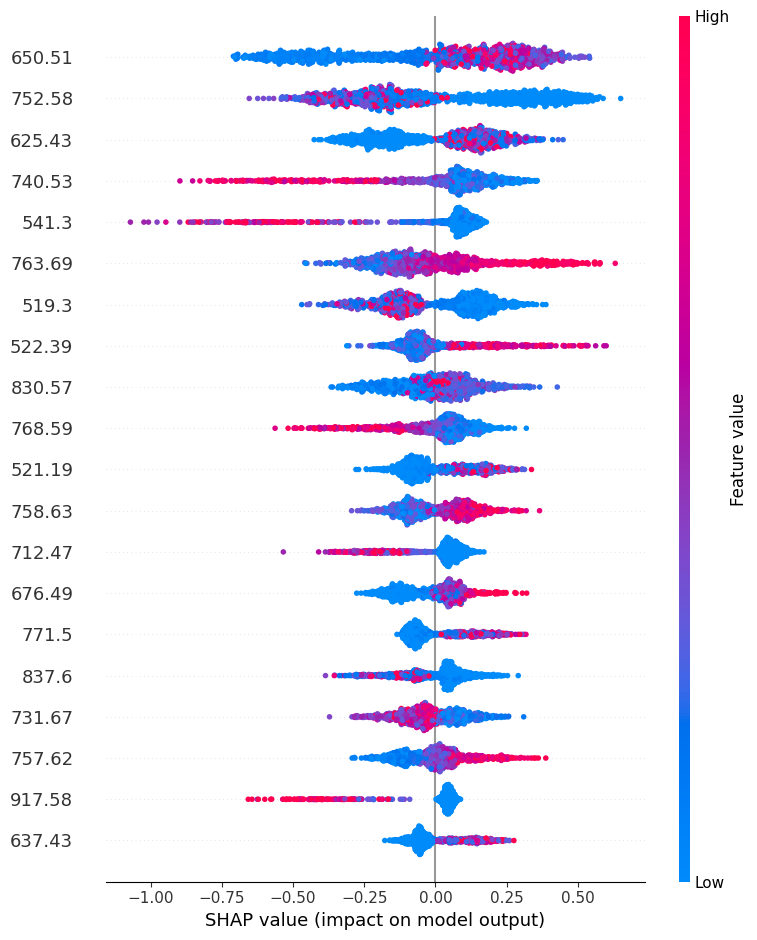

In [40]:
# Create an explainer object
explainer = shap.TreeExplainer(xgb)

# Compute SHAP values for all features
shap_values = explainer.shap_values(MyData.X_train)  # Replace X with your actual data

# Summarize the SHAP values
shap.summary_plot(shap_values, MyData.X_train)  # Replace X with your actual data

### PDP plot

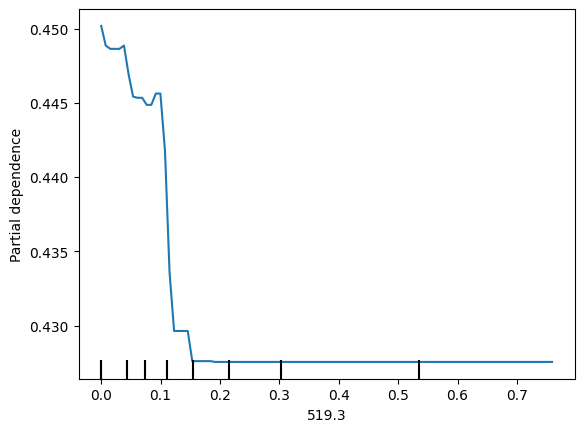

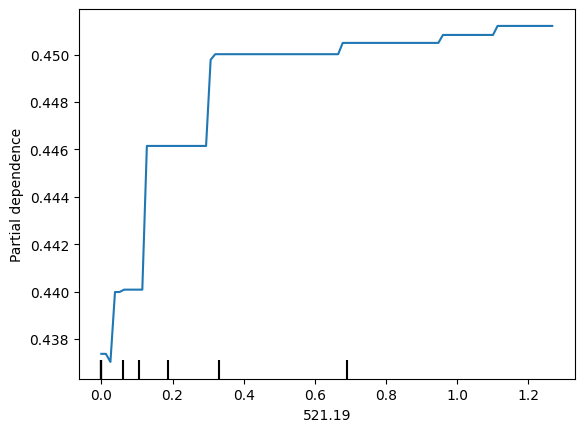

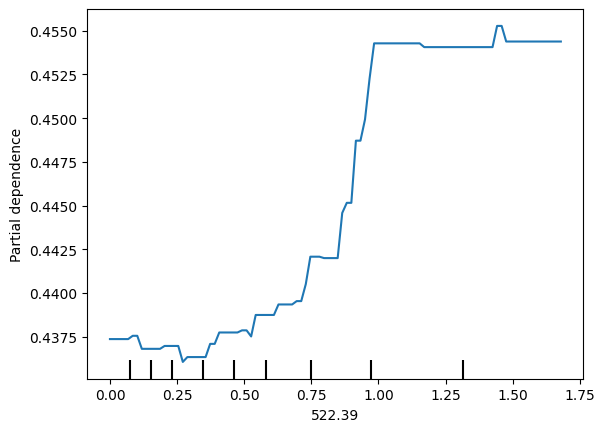

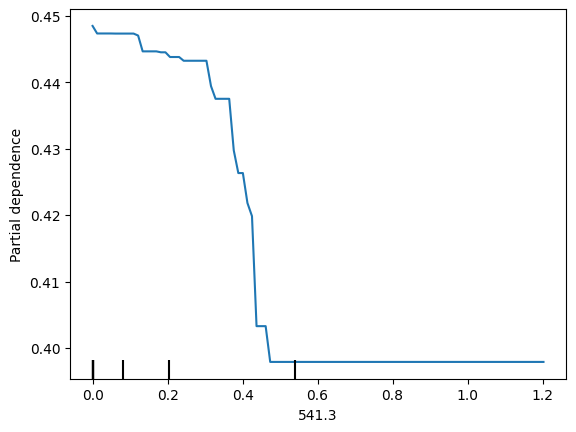

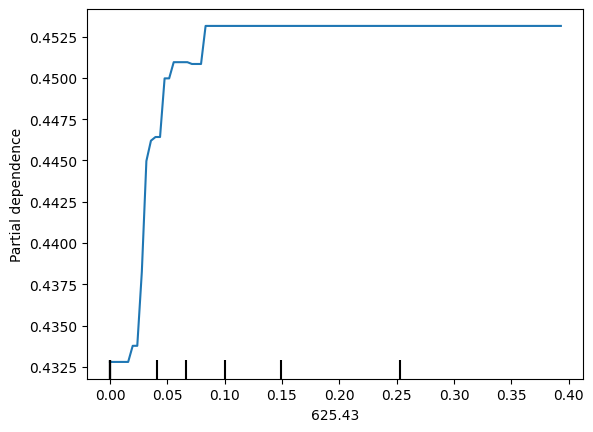

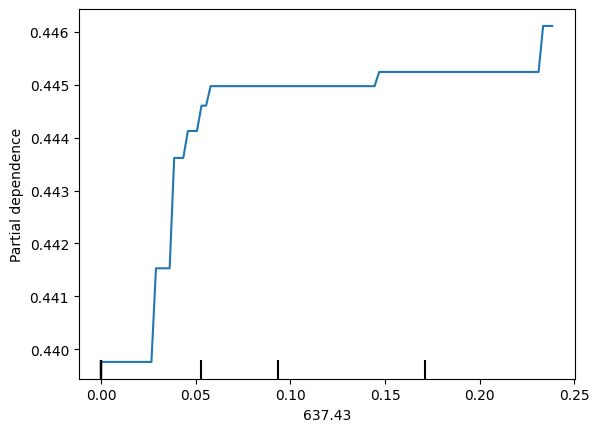

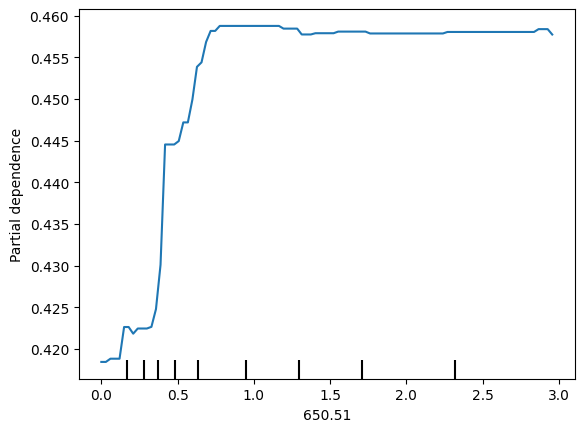

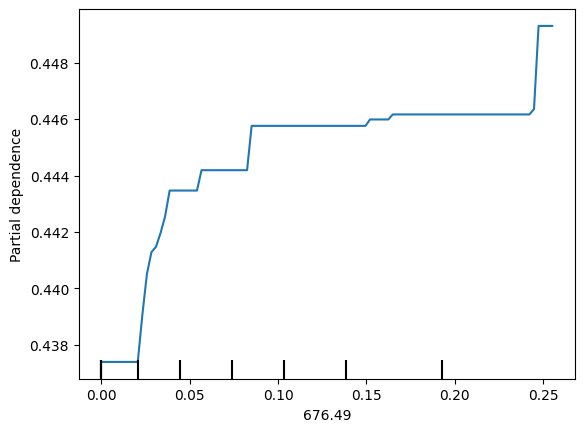

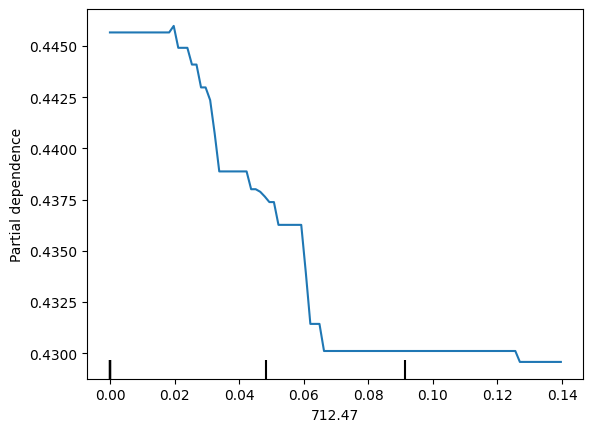

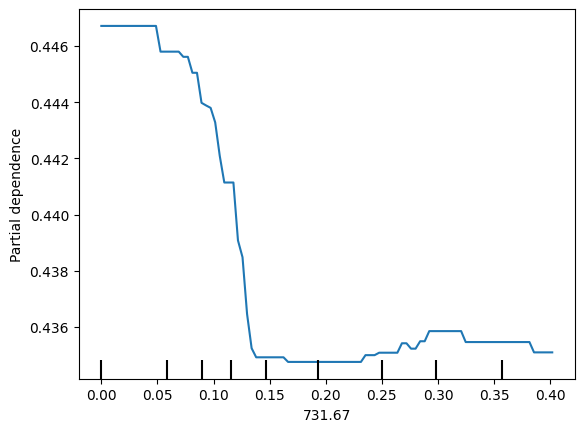

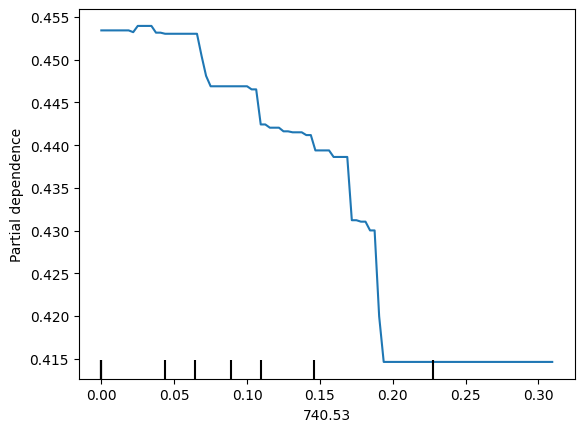

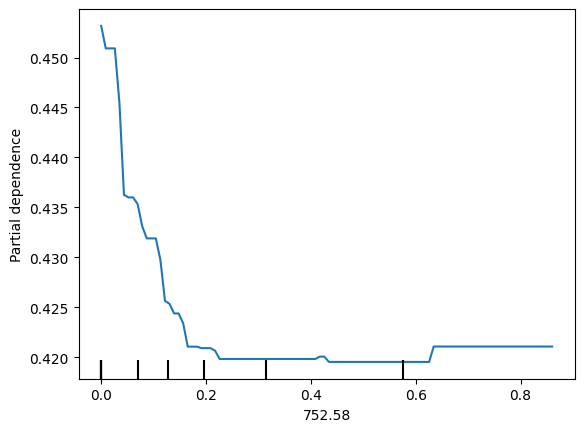

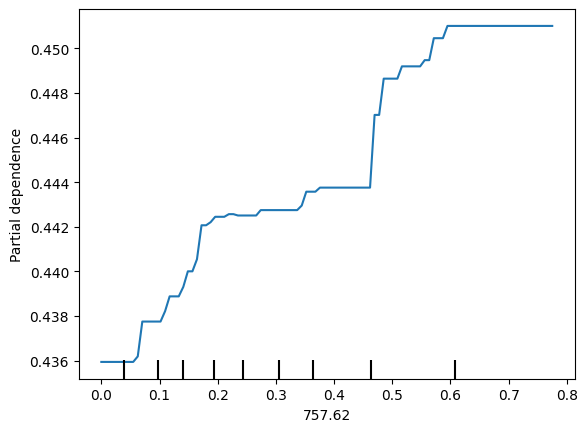

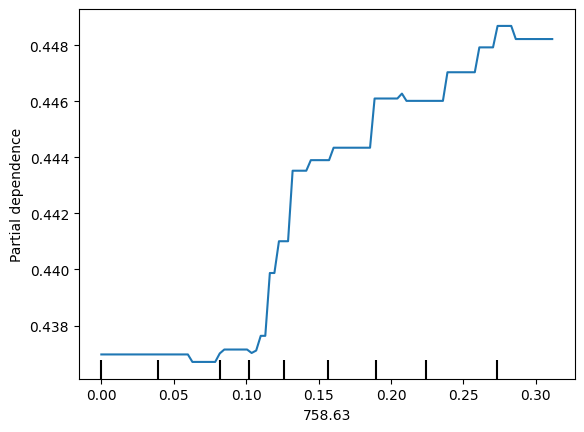

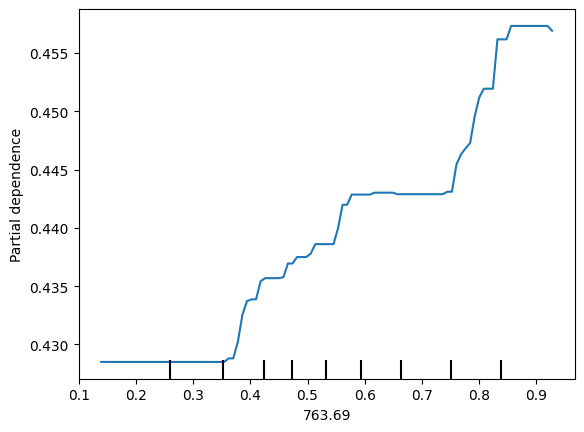

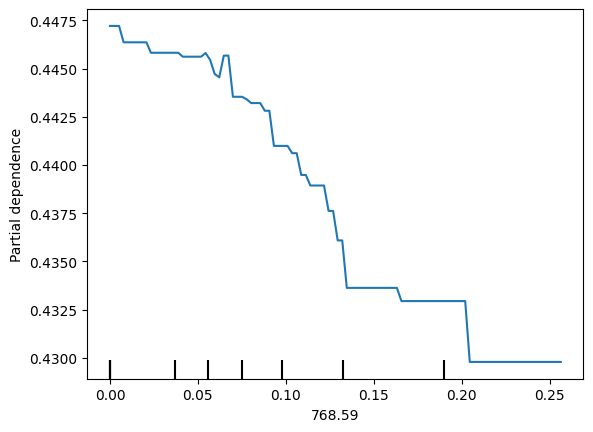

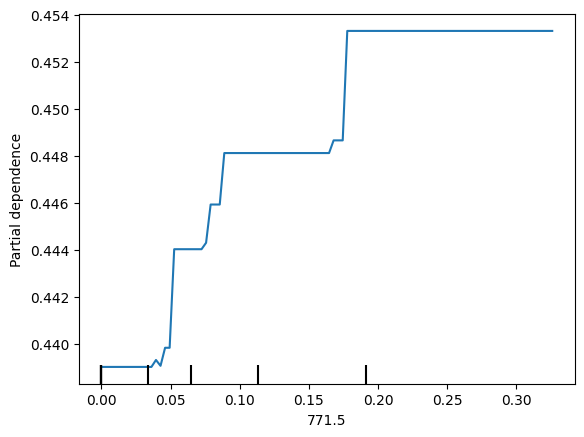

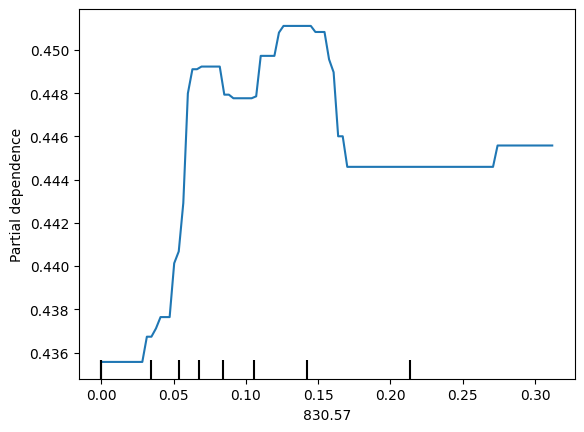

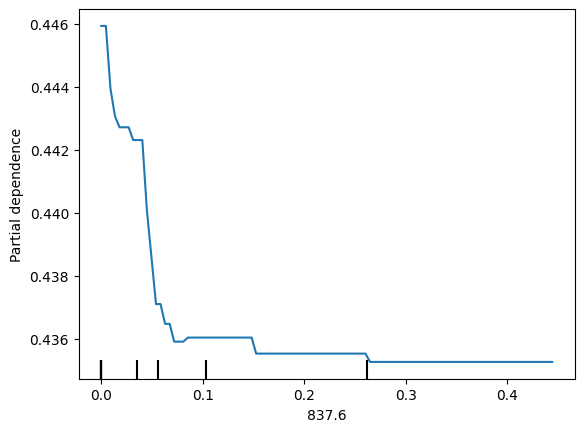

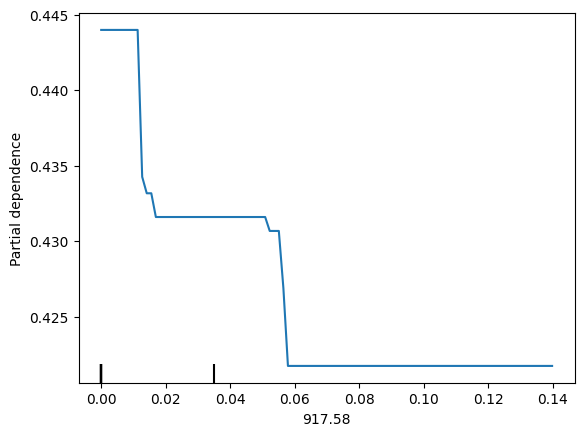

In [51]:
from sklearn.inspection import PartialDependenceDisplay

for i in range(MyData.X_train.shape[1]):
    if MyData.X_train.columns[i] in [650.51, 752.58, 625.43, 740.53, 541.3, 763.69, 519.3, 522.39, 830.57, 768.59, 521.19, 758.63, 712.47, 676.49, 771.5, 837.6, 731.67, 757.62, 917.58, 637.43]:
        PartialDependenceDisplay.from_estimator(xgb, MyData.X_train, [i])
        plt.show()